In [62]:
#pip install geopandas

In [63]:
import pandas as pd
import numpy as np
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

In [64]:
df = pd.read_csv('data/ebd_US-IL_200801_201212_relJan-2024.txt',sep='\t')

In [65]:
df = df.loc[:, ['CATEGORY', 'COMMON NAME', 'SCIENTIFIC NAME', 'OBSERVATION COUNT', 'EXOTIC CODE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'PROTOCOL TYPE', 'ALL SPECIES REPORTED']]
df.head()

,CATEGORY,COMMON NAME,SCIENTIFIC NAME,OBSERVATION COUNT,EXOTIC CODE,LATITUDE,LONGITUDE,OBSERVATION DATE,PROTOCOL TYPE,ALL SPECIES REPORTED
0,species,American White Pelican,Pelecanus erythrorhynchos,49,NaN,37.104636,-89.370953,2008-01-12,Historical,0
1,species,American Crow,Corvus brachyrhynchos,X,NaN,38.850907,-89.256706,2008-01-01,Traveling,1
2,species,American Goldfinch,Spinus tristis,X,NaN,38.850907,-89.256706,2008-01-01,Traveling,1
3,species,American Kestrel,Falco sparverius,X,NaN,38.850907,-89.256706,2008-01-01,Traveling,1
4,species,Bald Eagle,Haliaeetus leucocephalus,X,NaN,38.850907,-89.256706,2008-01-01,Traveling,1


## Filtering eBird Dataset

In [66]:
df['CATEGORY'].unique()

array(['species', 'issf', 'domestic', 'slash', 'form', 'spuh', 'hybrid',
       'intergrade'], dtype=object)

In [67]:
df['PROTOCOL TYPE'].unique()

array(['Historical', 'Traveling', 'Incidental', 'Stationary', 'Area',
       'International Shorebird Survey (ISS)', 'Banding',
       'Rusty Blackbird Spring Migration Blitz',
       'Standardized Yard Count', 'Greater Gulf Refuge Waterbird Count',
       'Nocturnal Flight Call Count'], dtype=object)

We will keep only species level observations (removing subspecies and genus level observations). We will also filter out incomplete checklists and incidental observations to manage bias towards specific species. 

In [68]:
# Applying filters
df = df[(df['CATEGORY']=='species') & (df['PROTOCOL TYPE']=='Traveling') | (df['PROTOCOL TYPE']=='Stationary') & (df['ALL SPECIES REPORTED']==1)]

In [69]:
df.head()

,CATEGORY,COMMON NAME,SCIENTIFIC NAME,OBSERVATION COUNT,EXOTIC CODE,LATITUDE,LONGITUDE,OBSERVATION DATE,PROTOCOL TYPE,ALL SPECIES REPORTED
1,species,American Crow,Corvus brachyrhynchos,X,NaN,38.850907,-89.256706,2008-01-01,Traveling,1
2,species,American Goldfinch,Spinus tristis,X,NaN,38.850907,-89.256706,2008-01-01,Traveling,1
3,species,American Kestrel,Falco sparverius,X,NaN,38.850907,-89.256706,2008-01-01,Traveling,1
4,species,Bald Eagle,Haliaeetus leucocephalus,X,NaN,38.850907,-89.256706,2008-01-01,Traveling,1
5,species,Blue Jay,Cyanocitta cristata,X,NaN,38.850907,-89.256706,2008-01-01,Traveling,1


## ebird Dataset Transformation

In [70]:
# Native column: 1 = is native to chicago, 0 = not native to chicago
def exotic_trans(row):
    if row == np.nan:
        return 0
    else:
        return 1

df['NATIVE'] = df['EXOTIC CODE'].apply(exotic_trans)

In [71]:
# Assume all 'X' observations have a count of 1 bird
def obs_trans(row):
    if row == 'X':
        return 1
    else:
        return row

df['COUNT'] = df['OBSERVATION COUNT'].apply(obs_trans)

In [72]:
# remove unnecessary columns
df = df.loc[:, ['COMMON NAME', 'SCIENTIFIC NAME', 'NATIVE', 'COUNT', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE']]
df.head()

,COMMON NAME,SCIENTIFIC NAME,NATIVE,COUNT,LATITUDE,LONGITUDE,OBSERVATION DATE
1,American Crow,Corvus brachyrhynchos,1,1,38.850907,-89.256706,2008-01-01
2,American Goldfinch,Spinus tristis,1,1,38.850907,-89.256706,2008-01-01
3,American Kestrel,Falco sparverius,1,1,38.850907,-89.256706,2008-01-01
4,Bald Eagle,Haliaeetus leucocephalus,1,1,38.850907,-89.256706,2008-01-01
5,Blue Jay,Cyanocitta cristata,1,1,38.850907,-89.256706,2008-01-01


## Aggregate eBird data based on neighborhood

In [73]:
com_areas = gpd.read_file('data/neighborhoods/geo_export_f5325bf0-9c6d-49a5-a5d9-0e5bf24fa856.shp')

In [74]:
com_areas = com_areas.loc[:,['community','geometry']]
com_areas.head()

,community,geometry
0,DOUGLAS,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,OAKLAND,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,FULLER PARK,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,GRAND BOULEVARD,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,KENWOOD,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."


In [75]:
len(com_areas)

77

In [76]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

In [77]:
geo_df.head()

,COMMON NAME,SCIENTIFIC NAME,NATIVE,COUNT,LATITUDE,LONGITUDE,OBSERVATION DATE,geometry
1,American Crow,Corvus brachyrhynchos,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091)
2,American Goldfinch,Spinus tristis,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091)
3,American Kestrel,Falco sparverius,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091)
4,Bald Eagle,Haliaeetus leucocephalus,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091)
5,Blue Jay,Cyanocitta cristata,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091)


In [78]:
ebird_gdf = gpd.sjoin(geo_df, com_areas, how='left', op='within')

In [79]:
ebird_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1435454 entries, 1 to 2056230
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   COMMON NAME       1435454 non-null  object  
 1   SCIENTIFIC NAME   1435454 non-null  object  
 2   NATIVE            1435454 non-null  int64   
 3   COUNT             1435454 non-null  object  
 4   LATITUDE          1435454 non-null  float64 
 5   LONGITUDE         1435454 non-null  float64 
 6   OBSERVATION DATE  1435454 non-null  object  
 7   geometry          1435454 non-null  geometry
 8   index_right       277170 non-null   float64 
 9   community         277170 non-null   object  
dtypes: float64(3), geometry(1), int64(1), object(5)
memory usage: 120.5+ MB


In [80]:
ebird_gdf.head()

,COMMON NAME,SCIENTIFIC NAME,NATIVE,COUNT,LATITUDE,LONGITUDE,OBSERVATION DATE,geometry,index_right,community
1,American Crow,Corvus brachyrhynchos,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091),NaN,NaN
2,American Goldfinch,Spinus tristis,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091),NaN,NaN
3,American Kestrel,Falco sparverius,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091),NaN,NaN
4,Bald Eagle,Haliaeetus leucocephalus,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091),NaN,NaN
5,Blue Jay,Cyanocitta cristata,1,1,38.850907,-89.256706,2008-01-01,POINT (-89.25671 38.85091),NaN,NaN


In [81]:
# remove observations outside of Chicago
ebird_gdf = ebird_gdf[ebird_gdf['community'].notna()]

In [82]:
# also remove more unnecessary columns
ebird_gdf = ebird_gdf.drop(columns=["index_right","LATITUDE","LONGITUDE","OBSERVATION DATE", "COMMON NAME"])

In [83]:
ebird_gdf.dtypes

SCIENTIFIC NAME      object
NATIVE                int64
COUNT                object
geometry           geometry
community            object
dtype: object

In [84]:
ebird_gdf['COUNT'] = ebird_gdf['COUNT'].astype(int)

In [85]:
# aggregate 
def agg_comm(series):
    return list(series)

grouped = ebird_gdf.groupby('community').agg(agg_comm)
grouped['NATIVE'] = grouped['NATIVE'].apply(lambda x: sum(x))

In [86]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, ALBANY PARK to WOODLAWN
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SCIENTIFIC NAME  53 non-null     object
 1   NATIVE           53 non-null     int64 
 2   COUNT            53 non-null     object
 3   geometry         53 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.1+ KB


In [87]:
grouped = grouped.drop(columns=['geometry'])

In [88]:
grouped.head()

,SCIENTIFIC NAME,NATIVE,COUNT
community,,,
ALBANY PARK,"[Spinus tristis, Megaceryle alcyon, Cyanocitta...",1281,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, ..."
ARMOUR SQUARE,"[Turdus migratorius, Branta canadensis, Aegoli...",35,"[1, 1, 1, 1, 6, 3, 1, 1, 5, 2, 5, 1, 1, 1, 1, ..."
AUSTIN,"[Branta canadensis, Branta canadensis, Dryobat...",16232,"[375, 380, 1, 19, 2, 1, 6, 7, 1, 1, 48, 6, 1, ..."
AVONDALE,"[Corvus brachyrhynchos, Branta canadensis, Buc...",97,"[1, 45, 1, 12, 1, 1, 7, 3, 1, 1, 2, 34, 1, 77,..."
BELMONT CRAGIN,"[Setophaga ruticilla, Setophaga ruticilla, Tur...",123,"[2, 2, 10, 10, 1, 1, 2, 2, 1, 1, 2, 2, 10, 10,..."


In [89]:
com_areas = com_areas.to_crs(epsg=3857)
com_areas["Area"] = com_areas['geometry'].area / 10 ** 6
print(com_areas['Area'])

0      7.704645
1      2.831664
2      3.332879
3      8.115722
4      4.864822
        ...    
72    12.603975
73    15.318321
74    62.549480
75     8.152617
76     5.327034
Name: Area, Length: 77, dtype: float64


In [90]:
com_area_size = com_areas[["community","Area"]]
grouped = grouped.merge(com_area_size,on="community",how="left")

In [91]:
grouped.head(5)

,community,SCIENTIFIC NAME,NATIVE,COUNT,Area
0,ALBANY PARK,"[Spinus tristis, Megaceryle alcyon, Cyanocitta...",1281,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, ...",9.004359
1,ARMOUR SQUARE,"[Turdus migratorius, Branta canadensis, Aegoli...",35,"[1, 1, 1, 1, 6, 3, 1, 1, 5, 2, 5, 1, 1, 1, 1, ...",4.651178
2,AUSTIN,"[Branta canadensis, Branta canadensis, Dryobat...",16232,"[375, 380, 1, 19, 2, 1, 6, 7, 1, 1, 48, 6, 1, ...",33.432414
3,AVONDALE,"[Corvus brachyrhynchos, Branta canadensis, Buc...",97,"[1, 45, 1, 12, 1, 1, 7, 3, 1, 1, 2, 34, 1, 77,...",9.289855
4,BELMONT CRAGIN,"[Setophaga ruticilla, Setophaga ruticilla, Tur...",123,"[2, 2, 10, 10, 1, 1, 2, 2, 1, 1, 2, 2, 10, 10,...",18.324439


## Join eBird and census datasets

In [92]:
census_df = pd.read_csv("data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012_20240228.csv")

In [93]:
census_df.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [94]:
census_df['COMMUNITY AREA NAME'] = census_df['COMMUNITY AREA NAME'].str.upper()

In [95]:
final_df = census_df.merge(grouped, left_on='COMMUNITY AREA NAME', right_on='community')
final_df.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,community,SCIENTIFIC NAME,NATIVE,COUNT,Area
0,1.0,ROGERS PARK,7.7,23.6,8.7,18.2,27.5,23939,39.0,ROGERS PARK,"[Spinus tristis, Turdus migratorius, Turdus mi...",676,"[1, 46, 4, 9, 1, 3, 1, 9, 12, 1, 2, 1, 2, 1, 7...",8.631616
1,2.0,WEST RIDGE,7.8,17.2,8.8,20.8,38.5,23040,46.0,WEST RIDGE,"[Sturnus vulgaris, Aquila chrysaetos, Passer d...",255,"[7, 1, 5, 4, 100, 2, 2, 2, 1, 1, 1, 25, 25, 25...",16.570330
2,3.0,UPTOWN,3.8,24.0,8.9,11.8,22.2,35787,20.0,UPTOWN,"[Corvus brachyrhynchos, Corvus brachyrhynchos,...",75132,"[5, 7, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",10.946406
3,4.0,LINCOLN SQUARE,3.4,10.9,8.2,13.4,25.5,37524,17.0,LINCOLN SQUARE,"[Spinus tristis, Acanthis flammea, Junco hyema...",3751,"[1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",12.002108
4,5.0,NORTH CENTER,0.3,7.5,5.2,4.5,26.2,57123,6.0,NORTH CENTER,"[Corvus brachyrhynchos, Spinus tristis, Setoph...",1432,"[1, 7, 1, 28, 22, 4, 2, 5, 2, 1, 3, 2, 6, 2, 1...",9.588837


In [96]:
final_df = final_df.rename(columns={'PER CAPITA INCOME ': 'PER CAPITA INCOME'})

In [97]:
final_df["PER CAPITA INCOME IN K"] = final_df.apply(lambda x: x["PER CAPITA INCOME"] / 1000, axis=1)

In [98]:
final_df["CountPerSqkm"] = final_df.apply(lambda x: x["NATIVE"] / x["Area"],axis=1)

In [99]:
final_df["PovertyFlag"] = final_df.apply(lambda x: "Poor" if x["PER CAPITA INCOME"] < 40000 else "Rich", axis=1)

In [100]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Community Area Number                         52 non-null     float64
 1   COMMUNITY AREA NAME                           52 non-null     object 
 2   PERCENT OF HOUSING CROWDED                    52 non-null     float64
 3   PERCENT HOUSEHOLDS BELOW POVERTY              52 non-null     float64
 4   PERCENT AGED 16+ UNEMPLOYED                   52 non-null     float64
 5   PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  52 non-null     float64
 6   PERCENT AGED UNDER 18 OR OVER 64              52 non-null     float64
 7   PER CAPITA INCOME                             52 non-null     int64  
 8   HARDSHIP INDEX                                52 non-null     float64
 9   community                                     52 non-null     objec

In [101]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

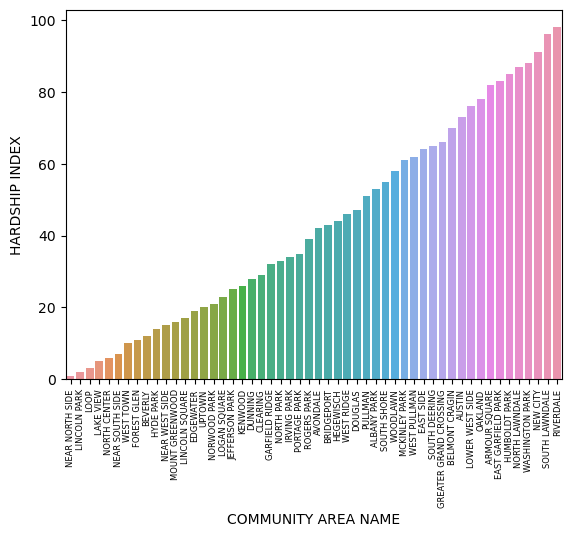

In [102]:
required_cols = ["COMMUNITY AREA NAME", "HARDSHIP INDEX"]

vis_df = final_df[required_cols].sort_values(by=["HARDSHIP INDEX"])

sns.barplot(data=vis_df, x=vis_df["COMMUNITY AREA NAME"], y=vis_df["HARDSHIP INDEX"])
plt.xticks(rotation=90,fontsize=6)
plt.show()

In [103]:
required_cols = ["CountPerSqkm","PER CAPITA INCOME IN K","PovertyFlag"]

vis_df = final_df[required_cols]
fig = px.scatter(vis_df,x='PER CAPITA INCOME IN K',y='CountPerSqkm',color='PovertyFlag',color_discrete_map = {0:'#636EFA',1: '#FFA15A'})
fig.update_layout(width=640,height=480,legend_title_text=None,yaxis_type="log")
fig.show()

In [104]:
def shannon_index(species_abundance):
    total_count = sum(species_abundance)
    proportions = [count / total_count for count in species_abundance]
    shannon_index = -sum(p * np.log(p) for p in proportions if p != 0)
    return shannon_index

In [105]:
final_df["shannon_index"] = final_df["COUNT"].apply(shannon_index)
final_df.head(5)

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,community,SCIENTIFIC NAME,NATIVE,COUNT,Area,PER CAPITA INCOME IN K,CountPerSqkm,PovertyFlag,shannon_index
0,1.0,ROGERS PARK,7.7,23.6,8.7,18.2,27.5,23939,39.0,ROGERS PARK,"[Spinus tristis, Turdus migratorius, Turdus mi...",676,"[1, 46, 4, 9, 1, 3, 1, 9, 12, 1, 2, 1, 2, 1, 7...",8.631616,23.939,78.316735,Poor,5.498251
1,2.0,WEST RIDGE,7.8,17.2,8.8,20.8,38.5,23040,46.0,WEST RIDGE,"[Sturnus vulgaris, Aquila chrysaetos, Passer d...",255,"[7, 1, 5, 4, 100, 2, 2, 2, 1, 1, 1, 25, 25, 25...",16.570330,23.040,15.388951,Poor,4.148305
2,3.0,UPTOWN,3.8,24.0,8.9,11.8,22.2,35787,20.0,UPTOWN,"[Corvus brachyrhynchos, Corvus brachyrhynchos,...",75132,"[5, 7, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",10.946406,35.787,6863.622752,Poor,9.626278
3,4.0,LINCOLN SQUARE,3.4,10.9,8.2,13.4,25.5,37524,17.0,LINCOLN SQUARE,"[Spinus tristis, Acanthis flammea, Junco hyema...",3751,"[1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",12.002108,37.524,312.528443,Poor,7.116321
4,5.0,NORTH CENTER,0.3,7.5,5.2,4.5,26.2,57123,6.0,NORTH CENTER,"[Corvus brachyrhynchos, Spinus tristis, Setoph...",1432,"[1, 7, 1, 28, 22, 4, 2, 5, 2, 1, 3, 2, 6, 2, 1...",9.588837,57.123,149.340322,Rich,6.540097


In [106]:
# json_data = final_df.to_json(orient='records', indent=4)
# # print(json_data)

# # Write JSON data to a file
# with open('final_data.json', 'w') as f:
#     f.write(json_data)

In [107]:
required_cols = ["shannon_index","PER CAPITA INCOME IN K","PovertyFlag"]

vis_df = final_df[required_cols]
fig = px.scatter(vis_df,x='PER CAPITA INCOME IN K',y='shannon_index',color='PovertyFlag',color_discrete_map = {0:'#636EFA',1: '#FFA15A'})
fig.update_layout(width=640,height=480,legend_title_text=None)
fig.show()

In [108]:
from sklearn.linear_model import LinearRegression

In [109]:
model = LinearRegression()
model.fit(final_df[['PER CAPITA INCOME']], final_df['shannon_index'])

LinearRegression()

In [110]:
# Predict
per_capita_income = np.array([[50000]])
prediction = model.predict(per_capita_income)
print("Prediction for X_new:", prediction)

Prediction for X_new: [6.27547626]
